In [123]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pylab as plt #for visualization
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from connection import db_string
from sqlalchemy import create_engine

In [110]:
engine = create_engine(db_string)

In [111]:
#print result of query
china_df = pd.read_sql(
    '''SELECT mid_year, population from populations where country_id = '1' ''',
    con = engine
)
china_df=china_df.rename(columns={"mid_year":"Year", "population":"Population (Thousands)"})
china_df

,Year,Population (Thousands)
0,1990,1172445
1,1991,1189184
2,1992,1204004
3,1993,1217129
4,1994,1228992
5,1995,1239940
6,1996,1249981
7,1997,1259067
8,1998,1267442
9,1999,1275407


### Data Prepocessing

Not much data prepocessing was necessary for this set of data. The data was retrieved from the SQL database using 'psycopg2' and placed into a Pandas DataFrame. The data was then split into a training set and a test set.

### Feature Engineering
As this was a dataset with only 2 features (time, and population in thousands) those were the two features used. A time-series analysis model was used so both columns, the value and time, were necessary.

In [112]:
#train test split
#lets do 6 years of training 4 of test
training_data = china_df[0:25]

test_data = china_df[25:]
test_data


,Year,Population (Thousands)
25,2015,1397029
26,2016,1403500
27,2017,1409517
28,2018,1415046
29,2019,1420062
30,2020,1424548
31,2021,1428481


### Training/Testing Split
The dataset used had 32 rows. A train/test ratio of ~80/20 was used as that ratio is usually regarded as a generally good starting split. In this case, the last 7 entries were used as the testing set.

In [113]:
#EDF

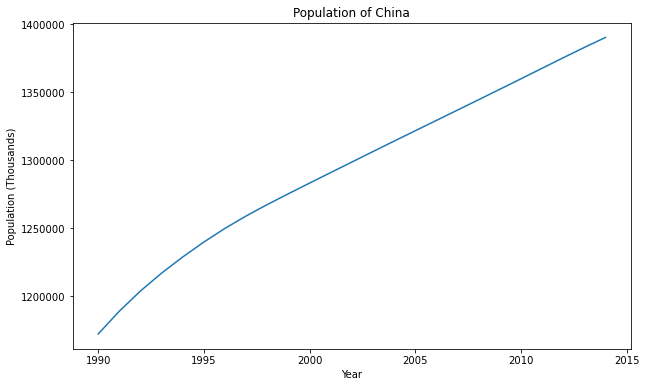

In [116]:
X_training=training_data['Year'].astype('int32')
y_training= training_data['Population (Thousands)'].astype('int32')
plt.plot(X_training,y_training)
plt.xlabel('Year')
plt.ylabel('Population (Thousands)')
plt.title(label='Population of China')
plt.ticklabel_format(style='plain')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

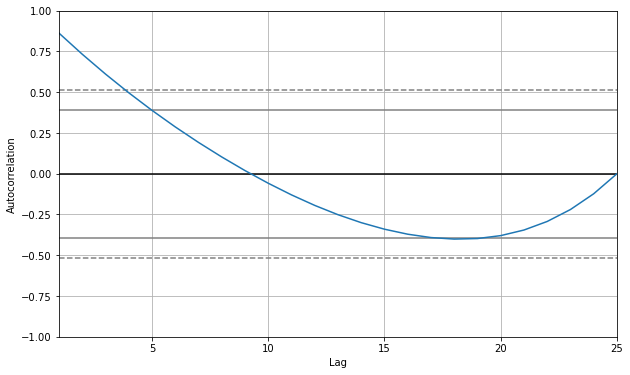

In [117]:
#auto correlation of un altered data. looking to see if it needs to be differenced
autocorrelation_plot(y_training)
#stays positive for about 9 lags
#probably needs to be differenced at least once

In [118]:
# checking stationarity with Augmented Dickey Fuller Test (adfuller)
result = adfuller(y_training)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.657430
p-value: 0.453169


In [119]:
#null value in this test is that the series is non-stationary
# p-value is large so we can't reject null hypothesis
# therefore series is non-stationary and needs to be differenced

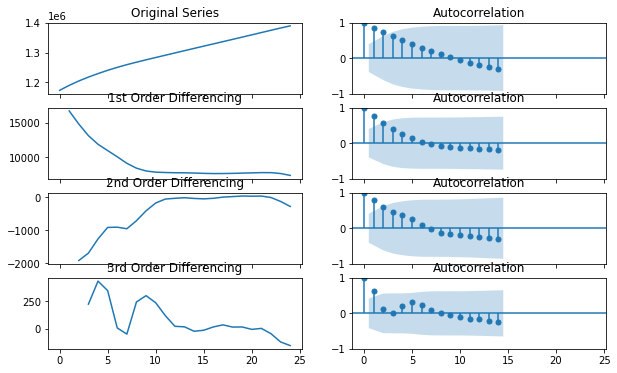

In [134]:
#exploring differencing
# Original Series

fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(y_training); axes[0, 0].set_title('Original Series')
plot_acf(y_training, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_training.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_training.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_training.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_training.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(y_training.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [135]:
# doesn't reach stationarity but 
# the 3rd order differencing has the autocorrelation reach 0 the fastest (around 2-3 lags) any higher order would 
# most likely make it dip into the negatives too quickly
# so try d at 3

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


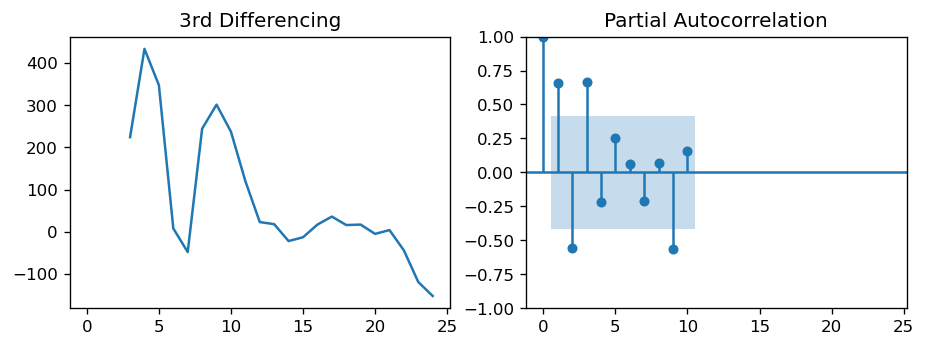

In [140]:
#partial auto correlation to find p term
# PACF plot of 3rd differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_training.diff().diff().diff().dropna(), ax=axes[1], lags = 10)

plt.show()

In [ ]:
# value at first lag is significant (outside of the blue boxed region)
# significant at lag 2 as well but will set p at 1 for now

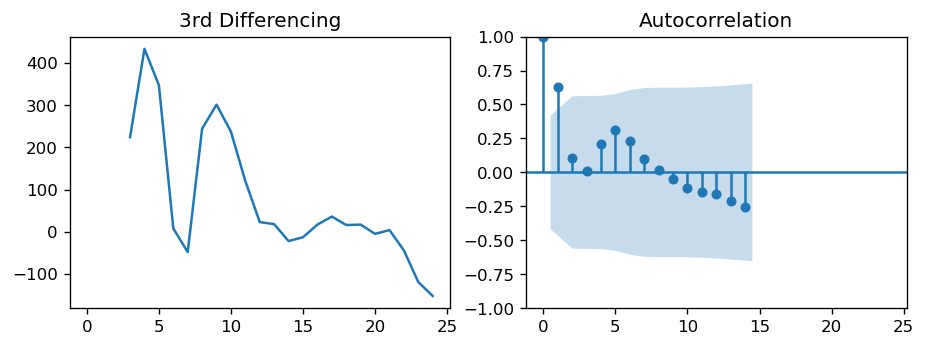

In [142]:
#auto correlation for differenced series to find q value
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_training.diff().diff().diff()); axes[0].set_title('3rd Differencing')
axes[1].set(ylim=(0,5))
plot_acf(y_training.diff().diff().diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
#similar to pacf
# 1 and 2 are signifcant
# will start with 1 but 2 could also work

In [13]:
#orders for arima model 
#(p,d,q)
# (1,3,1)

### Model Choice and Pros/Cons
The model chosen was an ARIMA (auto-regressive integrated moving average) model. ARIMA is a popularly used model for time-series forecasting. Advantages of this model include; it is a recursive forecasting method (as opposed to a direct method) meaning the model can be used to forecast different time-steps by using the previous prediction as the input for the next prediction and its extendability (able to extend how far into the future the predictions are, this is due to its recursiveness). Meanwhile, the disadvantages of this model are; its poorer performance over longer periods of time and that it has difficulty predicting turning points. The ARIMA model can also be more difficult, for those who are not highly experienced with the model, to adjust and optimize than other time-series forecasting models such as a neural network.

                                 SARIMAX Results                                  
Dep. Variable:     Population (Thousands)   No. Observations:                   25
Model:                     ARIMA(1, 3, 1)   Log Likelihood                -143.983
Date:                    Wed, 20 Jul 2022   AIC                            293.967
Time:                            18:45:54   BIC                            297.240
Sample:                                 0   HQIC                           294.738
                                     - 25                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9925      1.221     -0.813      0.416      -3.385       1.400
ma.L1          0.9927      1.220      0.814      0.416      -1.398       3.384
sigma2      2.832e+0

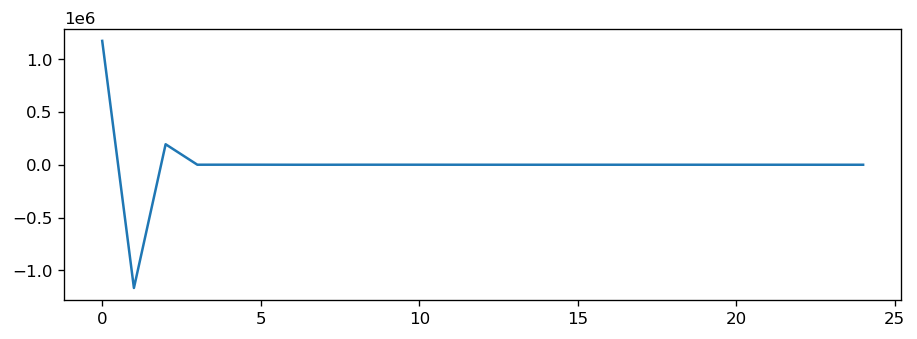

In [220]:
#arima model
model = ARIMA(y_training, order=(1,3,1))
results_AR = model.fit()
print(results_AR.summary())
residuals = results_AR.resid
residuals.plot()
plt.show()


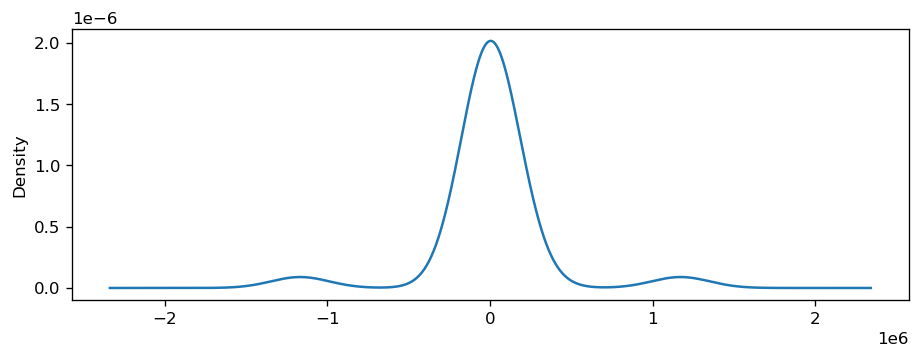

count    2.500000e+01
mean     8.055800e+03
std      3.398383e+05
min     -1.166673e+06
25%     -1.574794e+01
50%      2.206467e+01
75%      2.434099e+02
max      1.172445e+06
dtype: float64


In [221]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [222]:
#making predictions
y_pred = pd.Series(results_AR.forecast(7))
y_pred

25    1.397156e+06
26    1.403925e+06
27    1.410422e+06
28    1.416643e+06
29    1.422592e+06
30    1.428264e+06
31    1.433665e+06
Name: predicted_mean, dtype: float64

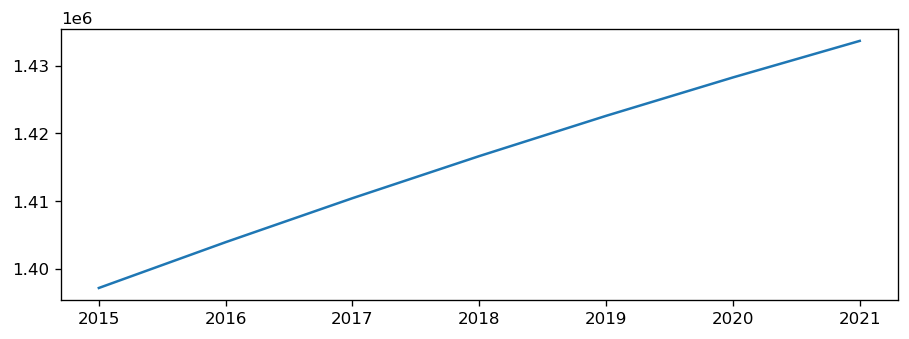

In [223]:
#rename forecast index to correct years
y_pred= y_pred.rename({25:2015, 26:2016, 27:2017, 28:2018, 29:2019, 30:2020, 31:2021})
y_pred.plot()
plt.show()


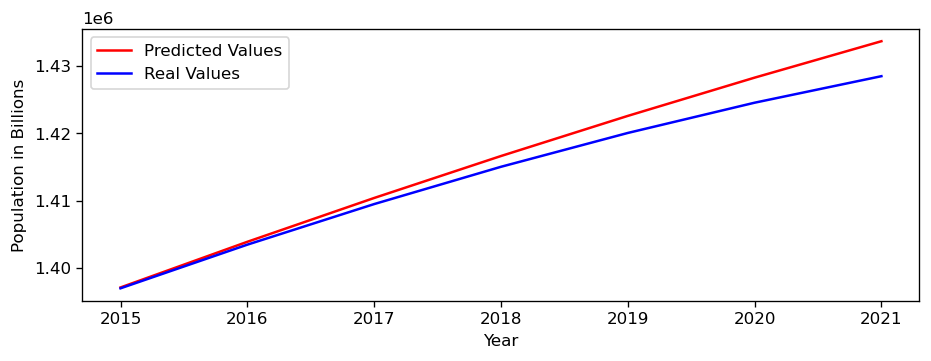

In [224]:
#now plot the model predictions and the test data
y_real = test_data['Population (Thousands)'].astype('int32')
y_real= y_real.rename({25:2015, 26:2016, 27:2017, 28:2018, 29:2019, 30:2020, 31:2021})
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Billions')
plt.legend()
plt.show()

In [225]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(y_training)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

MAPE: 0.0014546822121562501 
MASE: 0.22812879469239036


In [226]:
#mape and mase are good for time series as they can deal with the scale of a time series forecast better than other 
#methods of accuracy/error calculation

#mase compares the predictions of the model to a naive model, meaning a model that uses the last observed value as the value
# for all of the predictions
# a mase of 1 means that the model is just as accurate as picking the last observed value over and over as the prediction
# a mase of 0.5 means that the model is twice as accurate as the naive model


#the mape is a measure of error that is scale independent so it is useful for evaluating error of time series forecasting
#the mape is represented as a percentage
# so our mape of 0.04% should be considered a relatively good error.

In [70]:
#room for improvement for sure i think
# the forecasted plot looks very similar to the real values
#which suggests that the prediction is rather accurate.